In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
import glob
import gc
import os
def select_files_with_tr(directory, tr_number, nontremor = False):
    selected_files = []
    for filename in os.listdir(directory):
        if nontremor:
            if tr_number in filename and 'nontremor' not in filename:
                full_path = os.path.join(directory, filename)
                selected_files.append(full_path)
        elif    tr_number in filename :
                full_path = os.path.join(directory, filename)
                selected_files.append(full_path)

    return selected_files
train_path = '/home/xinyu/TremorProject/data/patient12_train/'
test_path = '/home/xinyu/TremorProject/data/Cwt_nontremor_data/'
tr_number = 'TR006'

def get_files(fpath,extension):
    files = glob.glob(f"{fpath}*.{extension}")
    return files

def get_train_files(all_files, test_files):
    return [file for file in all_files if file not in test_files]

pid_files = select_files_with_tr(train_path, tr_number)
test_files_tremor = select_files_with_tr(train_path, tr_number, True)
test_files_nontremor = select_files_with_tr(test_path, tr_number)

test_files = test_files_tremor + test_files_nontremor

all_files = get_files(train_path,'npy')

train_files = get_train_files(all_files, pid_files)



In [3]:
len(train_files)

74

In [4]:
test_files

['/home/xinyu/TremorProject/data/patient12_train/Copy of Copy of TR006_phase1_20190418092458_tremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR006_phase1_20190418092458_nontremor.npy',
 '/home/xinyu/TremorProject/data/Cwt_nontremor_data/TR006_phase3_20190418100558_nontremor.npy']

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class NpyDataset(Dataset):
    def __init__(self, file_path,transform=None):
        self.data = np.load(file_path,mmap_mode='r')
        self.num_samples = self.data.shape[0]
        self.file_name = os.path.basename(file_path)
        self.transform = transform
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        data_point = np.abs(self.data[idx])
        label = 0 if 'nontremor' in self.file_name else 1  # Example label logic
        if self.transform:
          data_point = self.transform(data_point)
        return torch.tensor(data_point, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [16]:
from torch.utils.data import DataLoader, ConcatDataset
class NormalizeToZeroOne:
    def __call__(self, x):
        x_min = x.min()
        x_max = x.max()
        return (x - x_min) / (x_max - x_min)

# Load datasets with the normalization transform
transform = NormalizeToZeroOne()

train_datasets = [NpyDataset(file_path, transform=transform) for file_path in train_files]
concat_dataset = ConcatDataset(train_datasets)
train_loader = DataLoader(concat_dataset , batch_size=64, shuffle=True)

test_datasets = [NpyDataset(file_path, transform=transform) for file_path in test_files]
concat_dataset = ConcatDataset(test_datasets)

test_loader = DataLoader(concat_dataset , batch_size=64, shuffle=False)

In [5]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [8]:
for data,label in train_loader:
    print(data.min())
    print(data.max())
    break

tensor(0.)
tensor(1.)


In [9]:
for data, label in train_loader:
    data = data
    break

In [6]:
class VAE(nn.Module):

     def __init__(self, z_dim=40):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
          nn.Conv2d(8, 32, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          View((-1, 128 * 16 * 16)),
          nn.Linear(128 * 16 * 16, z_dim * 2)  # Outputting mean and log-variance
      )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128 * 16 * 16),
            View((-1, 128, 16, 16)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 8, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
     def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

     def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

     def decode(self, z):
        return self.decoder(z)

     def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [7]:
def _save_checkpoint(ckp_path, model, epoch, optimizer, global_step):
    ## save checkpoint to ckp_path: 'checkpoint/step_100.pt'
    ckp_path = ckp_path + 'ckp_{}.pt'.format(epoch+1)
    checkpoint = {'epoch': epoch,
                  'global_step': global_step,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, ckp_path)

In [12]:
def loss_function(x, x_hat, mean, log_var):

    mse_loss = nn.MSELoss(reduction='sum')
    reproduction_loss = mse_loss (x_hat, x).div(64)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    print(reproduction_loss)

    return reproduction_loss + KLD

In [13]:
def loss_function(x, x_hat, mean, log_var):

    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum').div(64)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [7]:
seed = 1
torch.manual_seed(seed)
## choose GPU id
gpu_id =1  ## 1, 2, 3,4
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device('cuda', gpu_id)
else:
    device = torch.device('cpu')
print("device: ", device)
## random seed for cuda
if use_cuda:
    torch.cuda.manual_seed(72)
    
model = VAE().to(device)

device:  cuda:1


In [15]:
from torch.autograd import Variable
def train(model, epochs, device, x_dim=784):
  
    model.train()
    iteration = 0

    optimizer = Adam(model.parameters(), lr=1e-4)

    ckp_path = '/home/xinyu/TremorProject/code/checkpoint/new_40d_patient7/'
    if not os.path.exists(ckp_path):
        os.makedirs(ckp_path)

    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (data,_) in enumerate(train_loader):
            data = data.to(device)
            iteration += 1
            optimizer.zero_grad()

            x_hat, mean, log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()
            if iteration%10==0:
                  print('iter: {} loss: {}'.format(iteration, loss.item()))

        if epoch == 29:
            _save_checkpoint(ckp_path, model, epoch, optimizer, iteration)

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*64))
    return overall_loss

In [16]:
train(model,  epochs=30, device=device)

iter: 10 loss: 90999.46875
iter: 20 loss: 87757.875
iter: 30 loss: 84598.828125
iter: 40 loss: 81361.5859375
iter: 50 loss: 78455.921875
iter: 60 loss: 75953.234375
iter: 70 loss: 73139.0234375
iter: 80 loss: 71327.5703125
iter: 90 loss: 68264.859375
iter: 100 loss: 66438.125
iter: 110 loss: 64275.95703125
iter: 120 loss: 62647.34765625
iter: 130 loss: 60847.56640625
iter: 140 loss: 58500.5859375
iter: 150 loss: 56610.28515625
iter: 160 loss: 55762.9453125


KeyboardInterrupt: 

In [8]:
import torch.optim as optim
model = VAE().to(device)

# Load checkpoint
checkpoint_path = '/home/xinyu/TremorProject/code/checkpoint/new_40d_BCE_patient12/ckp_30.pt'
basecnn = '/home/xinyu/TremorProject/code/checkpoint/new_40d_patient3'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model state_dict
model.load_state_dict(checkpoint['model_state_dict'])

# Optional: Load optimizer state_dict if you want to continue training or use optimizer settings
optimizer = optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [15]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, z_dim, num_classes, dropout_rate=0.5):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(z_dim, 20)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first layer
        x = self.sigmoid(self.fc2(x))
        return x

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=40, hidden_size=50, num_layers=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        print(x.shape)
        # # Initialize hidden state and cell state
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # (num_layers, batch_size, hidden_size)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # (num_layers, batch_size, hidden_size)
        x = x.view(x.size(0), -1, 40)

        # LSTM forward pass
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Take the output from the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, output_size)
        
        return out

In [ ]:
def _compute_counts(y_pred, y_batch, mode='train'):
    return (y_pred==y_batch).sum().item()

In [10]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split
datasets = [NpyDataset(file_path, transform=transform) for file_path in train_files]

def create_proportional_subset(dataset, percentage):
    num_samples = len(dataset)
    subset_indices = np.random.choice(num_samples, int(num_samples * percentage), replace=False)
    return Subset(dataset, subset_indices), subset_indices

def create_test_set(dataset, train_indices):
    all_indices = np.arange(len(dataset))
    test_indices = np.setdiff1d(all_indices, train_indices)
    return Subset(dataset, test_indices)

data_percentage = 1

# Create proportional subsets for each dataset and corresponding test sets
train_subsets = []
test_subsets = []

for dataset in datasets:
    train_subset, train_indices = create_proportional_subset(dataset, data_percentage)
    test_subset = create_test_set(dataset, train_indices)
    train_subsets.append(train_subset)
    test_subsets.append(test_subset)
concat_train_dataset = ConcatDataset(train_subsets)
concat_test_dataset = ConcatDataset(test_subsets)

train_size = int(len(concat_train_dataset) * 0.01)
valid_size = len(concat_train_dataset) - train_size  # Remaining 20% for testing

# Split train_subset into training and testing subsets
train_dataset, valid_subset = random_split(concat_train_dataset, [train_size, valid_size])

# Create DataLoader for each subset dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False) 

In [17]:
len(train_loader)

11

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from torch.utils.data import DataLoader
# Define number of classes
num_classes = 1  # For binary classification

# Instantiate VAE and classifier
vae = model
classifier = LSTM()

# Freeze the encoder parameters
for param in vae.encoder.parameters():
    param.requires_grad = False

# Define loss and optimizer for the classifier
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.005)  # Optionally adjust the learning rate

# Training loop
num_epochs = 40
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
vae.to(device)
classifier.to(device)
iteration = 0
def compute_accuracy(outputs, labels):
    predicted = (outputs > 0.5).float()
    correct = (predicted == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy

all_predictions = []
all_labels = []
classifier.train()
for epoch in range(num_epochs):
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        iteration+=1
        mu, logvar = vae.encode(data)
        z = vae.reparameterize(mu, logvar)
     
        outputs = classifier(z)
        labels = labels.float().unsqueeze(1)  # Ensure labels are in the correct shape
        # Compute loss
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        accuracy = compute_accuracy(outputs, labels)
        
        if iteration % 10 == 0:
            print(f'iter: {iteration} loss: {loss.item()}, accuracy: {accuracy.item()}')
        

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')


torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
iter: 10 loss: 0.6760866045951843, accuracy: 0.53125
torch.Size([24, 40])
Epoch [1/40], Loss: 0.6562, Accuracy: 0.4167
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
iter: 20 loss: 0.6076427102088928, accuracy: 0.609375
torch.Size([64, 40])
torch.Size([24, 40])
Epoch [2/40], Loss: 0.5895, Accuracy: 0.6667
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
iter: 30 loss: 0.5290068984031677, accuracy: 0.78125
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([24, 40])
Epoch [3/40], Loss: 0.4173, Accuracy: 0.8750
torch.Size([

In [15]:
import glob
import gc
def get_files(fpath,extension):
    files = glob.glob(f"{fpath}*.{extension}")
    return files

import os
def select_files_with_tr(directory, tr_number):
    selected_files = []
    for filename in os.listdir(directory):
        if tr_number in filename:
            full_path = os.path.join(directory, filename)
            selected_files.append(full_path)

    return selected_files

def get_all_files_except_selected(directory, selected_files):
    all_files = get_files(directory, 'npy')
    other_files = [f for f in all_files if f not in selected_files]
    return other_files
directory = '/home/xinyu/TremorProject/data/patient12_train/'
tr_number = 'TR006'

# Get the list of selected files
test_files = select_files_with_tr(directory, tr_number)

train_files = get_all_files_except_selected(directory, test_files)

torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([64, 40])
torch.Size([6

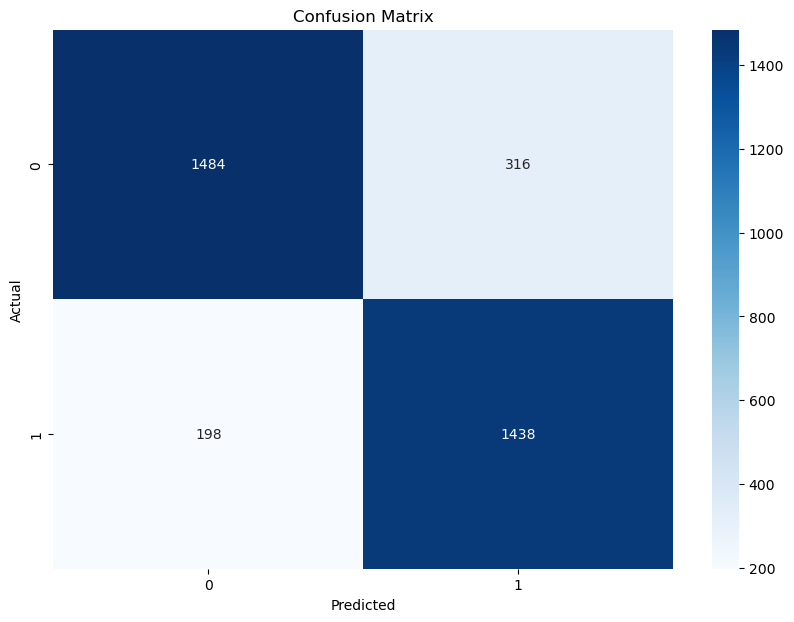

In [17]:
classifier.eval()  # Set model to evaluation mode

all_predictions = []
all_labels = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        mu, logvar = vae.encode(data)
        z = vae.reparameterize(mu, logvar)
        
        outputs = classifier(z)
        labels = labels.float().unsqueeze(1)  # Ensure labels are in the correct shape
        y_pred = (outputs >0.5).float()
        y_pred = y_pred.view(-1)
        # Store predictions and labels
        all_predictions.extend(y_pred.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions)
print(f'F1 Score: {f1}')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
test_files_tremor = test_files[:1]
tremor_datasets = [NpyDataset(file_path, transform=transform) for file_path in test_files_tremor]
concat_dataset = ConcatDataset(tremor_datasets)

tremor_loader = DataLoader(concat_dataset , batch_size=64, shuffle=False)

Accuracy: 0.4716981132075472
F1 Score: 0.6410256410256411


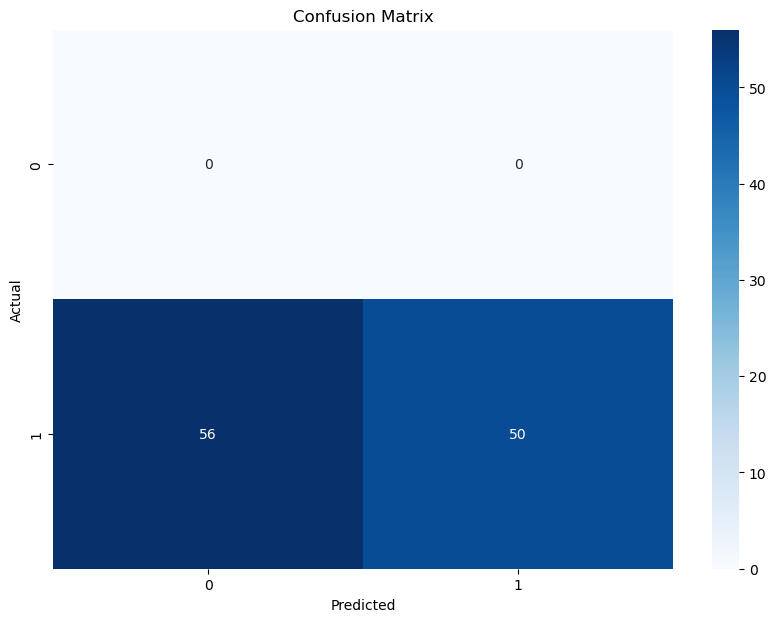

In [84]:
classifier.eval()  # Set model to evaluation mode

all_predictions = []
all_labels = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for data, labels in tremor_loader:
        data, labels = data.to(device), labels.to(device)
        mu, logvar = vae.encode(data)
        z = vae.reparameterize(mu, logvar)
        
        outputs = classifier(z)
        labels = labels.float().unsqueeze(1)  # Ensure labels are in the correct shape
        y_pred = (outputs >0.5).float()
        y_pred = y_pred.view(-1)
        # Store predictions and labels
        all_predictions.extend(y_pred.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions)
print(f'F1 Score: {f1}')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
different_indices = np.where(all_predictions ==0)[0]
print(different_indices)

[  0   1   3   4   5   6   7   8   9  10  12  13  16  17  20  22  27  29
  30  31  32  33  34  35  36  37  38  40  43  44  46  48  51  55  61  62
  63  64  65  68  74  76  77  78  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105]


In [27]:
data_points = []
tremor_data_points = []
zero_indices = different_indices.tolist()  # Convert to set for faster lookup
current_index = 0

for batch_data, batch_labels in tremor_loader:
    batch_size = len(batch_data)
    for i in range(batch_size):
        if current_index in zero_indices:
            data_points.append(batch_data[i])
        else:
            tremor_data_points.append(batch_data[i])
        current_index += 1

In [28]:
data_points[1].shape

torch.Size([8, 128, 128])

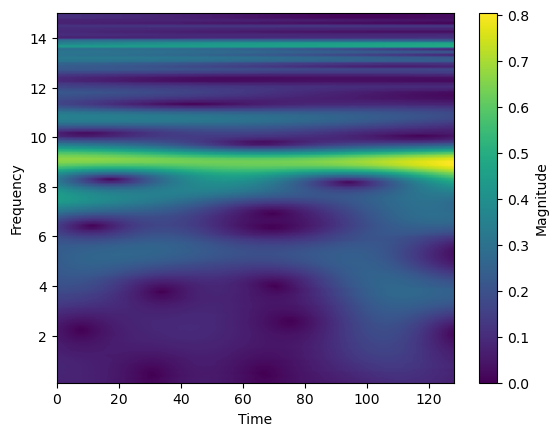

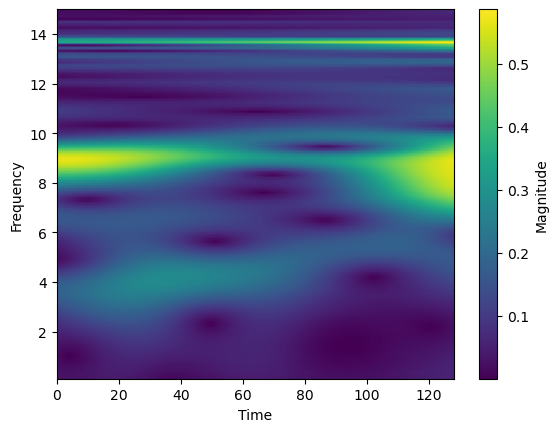

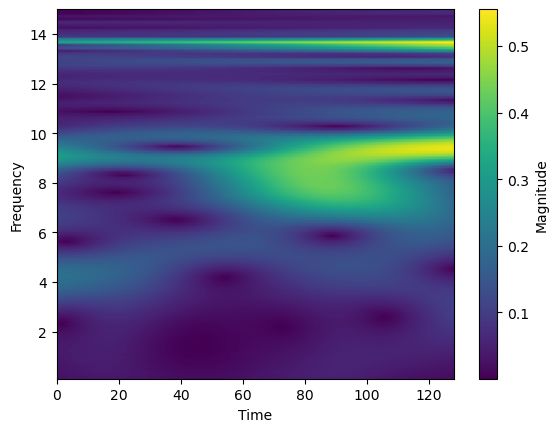

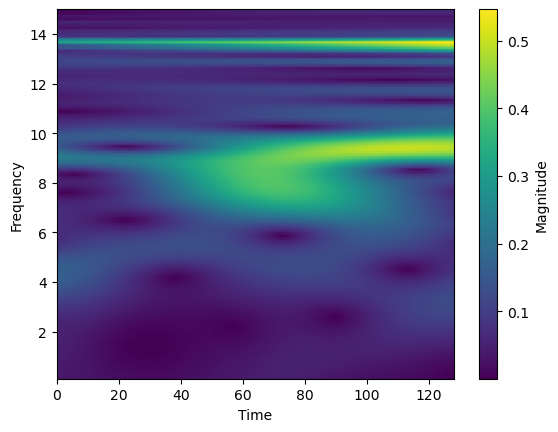

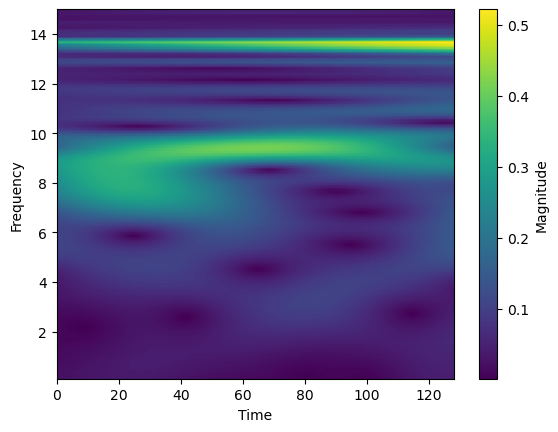

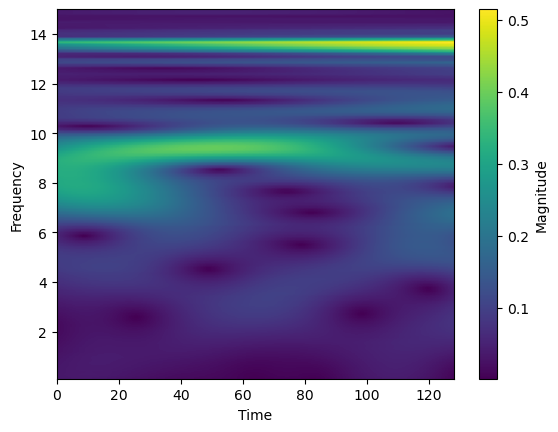

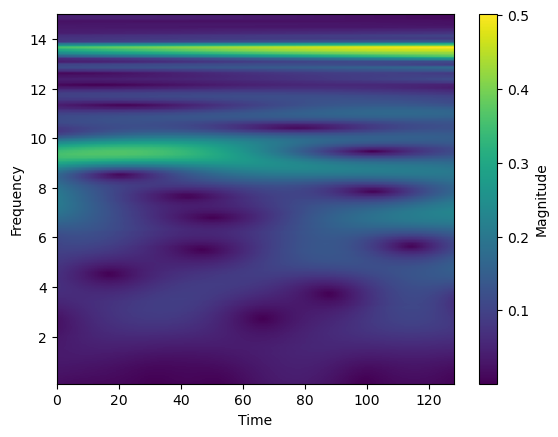

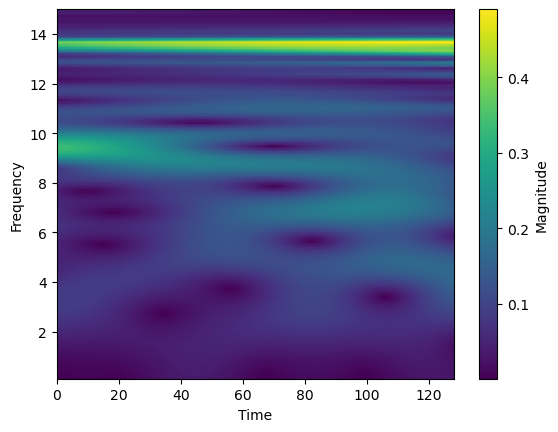

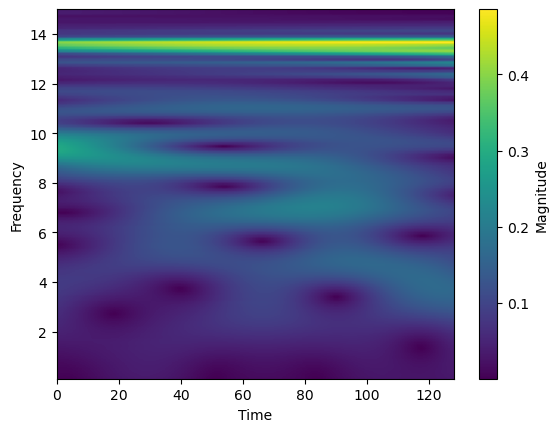

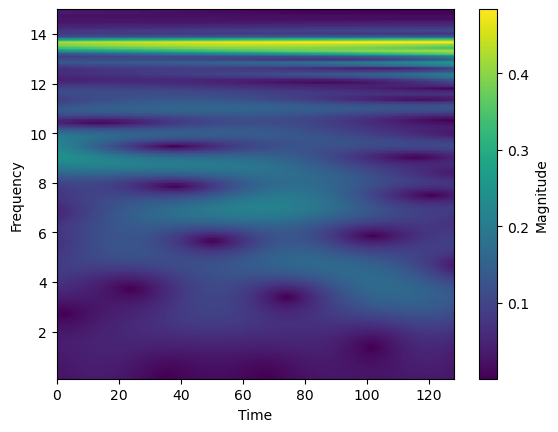

In [31]:
fs = 100  # Sampling frequency
n = fs * 7  # 100 seconds
ts = np.arange(n)

f0 = 0.1  # Lowest frequency
f1 = 15   # Highest frequency
fn = 100  # Number of frequencies
data_points = tremor_data_points[:10]
for i in data_points:
    plt.imshow(np.abs(i[3]), extent=[0, 128, f0, f1], aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
   
    plt.show()

In [ ]:
for i in data_points:
    

In [ ]:
latent_vectors = []
labels = []

# Extract latent vectors
with torch.no_grad():
    for data, label in train_loader:
        data = data.to(device)
        mu, logvar = vae.encode(data)
        latent_vectors.append(mu.cpu())
        labels.append(label.cpu())

latent_vectors = torch.cat(latent_vectors, dim=0)
labels = torch.cat(labels, dim=0)

In [ ]:
len(train_loader)

40

In [ ]:
latent_vectors.shape

torch.Size([2502, 20])

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Convert to numpy arrays
X = latent_vectors.numpy()
y = labels.numpy().ravel()  # Ensure labels are in the correct shape

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9885
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1103
           1       0.99      0.99      0.99      1149

    accuracy                           0.99      2252
   macro avg       0.99      0.99      0.99      2252
weighted avg       0.99      0.99      0.99      2252



In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu() # reshape vector to 2d array
    print(digit.shape)
    digit = digit[0][0].reshape(128, 128)
    plt.imshow(digit, cmap='rainbow')
    plt.axis('off')
    plt.show()

torch.Size([1, 8, 128, 128])


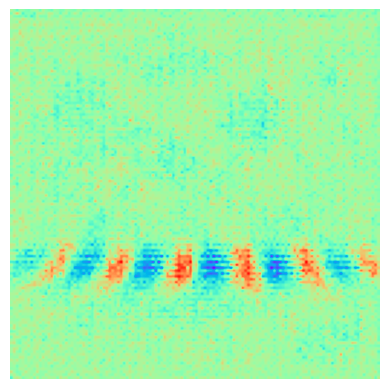

torch.Size([1, 8, 128, 128])


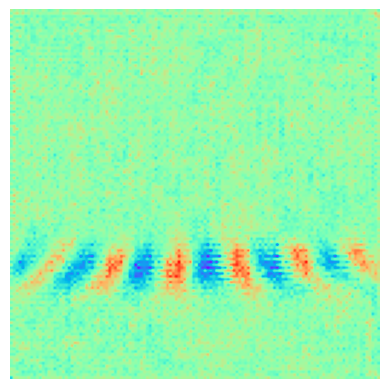

(None, None)

In [ ]:
generate_digit(0.5, 1.0), generate_digit(1.0, 0.0)

In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=128, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.detach().cpu() # reshape vector to 2d array
            print(digit.shape)
            digit = digit[0][0].reshape(128, 128)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure)
    plt.show()

In [ ]:
plot_latent_space(model)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 20x32768)

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_latent_space_tsne(model, data_loader, z_dim=40):
    # Ensure the model is in evaluation mode
    model.eval()

    # Collect latent vectors and corresponding labels
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
            data = data.to(device)
            mu, logvar = model.encode(data)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())

            labels.append(label.cpu().numpy())

    # Convert lists to numpy arrays
    latent_vectors = np.concatenate(latent_vectors, axis=0)[:]

    labels = np.concatenate(labels, axis=0)[:]

    # Apply t-SNE to the latent vectors
    tsne = TSNE(n_components=2, random_state=0)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis',s=0.3)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Visualization of VAE Latent Space')
    plt.show()

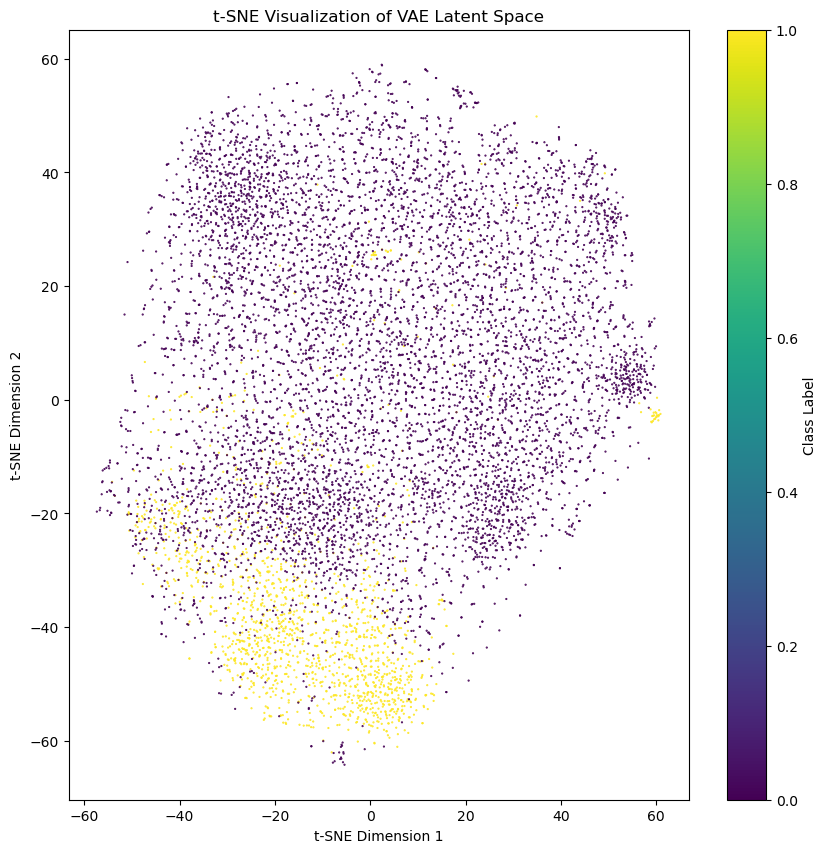

In [88]:
plot_latent_space_tsne(model, test_loader)

In [ ]:
plot_latent_space(model, train_loader,scale=1.0)

AttributeError: 'list' object has no attribute 'to'